In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import os

from background_models import bg_dampe, dphi_de_egb_fermi
from constants import dampe_excess_bin_high, dampe_bins, fermi_psf, t_universe
from constants import rho_earth, Hz_to_GeV2_cm3, GeV_to_m_sun, kpc_to_cm
from constants import fermi_psf_solid_angle, rho_max, dn_de_gamma_AP
from finite_clump_vectorized import rho_s_dampe, luminosity, dphi_de_g, rho
from finite_clump_vectorized import gamma_ray_extent, line_width_constraint
from finite_clump_vectorized import fermi_point_src_contraint#, anisotropy_constraint

from nfw_clump import NFW_params
from tt_clump import TT_params

colors = [c["color"] for c in plt.rcParams['axes.prop_cycle']]
# Photon energy at which to compute fluxes
e_gamma_ref = 230.
# Flux above which Fermi should absorb the clump as an extended source
dphi_de_g_fermi_ext = 1e-7  # (GeV cm^2 s sr)^2
# Significance used for line width constraint
n_sigma = 3.
# Directory with Ben's probability data files
pr_base_path = "../DAMPE+DM clumps/data/likelihoods/"

def mantissa_exp(x):
    exp = np.floor(np.log10(x))
    return x/10**exp, exp

def sci_fmt(val, fmt=".0f"):
    m, e = mantissa_exp(val)
    if e == 0:
        return (r"${:" + fmt + r"}$").format(m)
    else:
        e_str = "{:.0f}".format(e)
        if m == 1:
            return r"$10^{" + e_str + "}$"
        else:
            m_str = ("{:" + fmt + "}").format(m)
            return (r"${" + m_str + r"} \times 10^{" + e_str + "}$")

def log_levels(data, n=10):
    data = [d for d in data.flatten() if d != 0 and not np.isnan(d)]
    return np.logspace(np.log10(np.min(data)), np.log10(np.max(data)), n)

def normal_contours(dist, r_s, val, ax, levels=None, fmt=".0f"):
    """Creates density contour plot with labels.
    """
    if levels is None:
        levels = log_levels(val)
        
    cs = ax.contour(dist, r_s, val, levels=levels, norm=LogNorm())
    clabels = {level: (r"$" + ("{:" + fmt + "}").format(level) + r"$") for level in cs.levels}
    ax.clabel(cs, inline=True, fmt=clabels)

def sci_contours(dist, r_s, val, ax, levels=None, fmt=".0f"):
    """Creates density contour plot with labels using scientific notation.
    """
    if levels is None:
        levels = log_levels(val)

    cs = ax.contour(dist, r_s, val, levels=levels, norm=LogNorm())
    clabels = {level: sci_fmt(level, fmt) for level in cs.levels}
    ax.clabel(cs, inline=True, fmt=clabels)

def log_contours(dist, r_s, val, ax, levels=None):
    """Creates density contour plot with contour labels at powers of 10.
    """
    if levels is None:
        levels = log_levels(val)

    cs = ax.contour(dist, r_s, val, levels=levels, norm=LogNorm())
    clabels = {l: (r"$10^{%i}$" % np.log10(l)) for l in cs.levels}
    ax.clabel(cs, inline=True, fmt=clabels)
    
    
    cs = plt.contour(dist_pr, r_s_pr, val, levels=levels, norm=LogNorm())
    clabels = {pr: (r"$10^{%i}$" % np.log10(pr)) for pr in cs.levels}
    plt.clabel(cs, inline=True, fmt=clabels)

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/numba/dataflow.py:386: RuntimeWarning: Python2 style print partially supported.  Please use Python3 style print.
  "Python3 style print.", RuntimeWarning)


# NFW profile

In [16]:
# gamma_nfw = 0.5
gamma_nfw = 1.

dist = np.logspace(-3, 0, 50)
r_s = np.logspace(-3, 1, 50)
dist_mg, r_s_mg = np.meshgrid(dist, r_s)

base_path_nfw = 'data/nfw_gamma_%.1f/' % gamma_nfw

## Load results

In [91]:
for var in ["dist", "r_s"]:
    exec(var + " = np.loadtxt('" + base_path_nfw + var + ".csv', delimiter=',')")
dist_mg, r_s_mg = np.meshgrid(dist, r_s)

for var in ["rho_s", "rho_rel", "lum", "dphi_de_g", "extent", "lw",
            "rho_s_fermi_ps", "dphi_de_g_ext_rel"]:  #, "aniso_constr"]:
    exec(var + "_nfw = np.loadtxt('" + base_path_nfw + var + ".csv', delimiter=',')")

In [16]:
# Load likelihoods using Ben's processing
dist_pr, r_s_pr, pr_nfw = np.loadtxt(
    pr_base_path + "nfw/nfw_gamma_%.2f.csv" % gamma_nfw,
    delimiter=',').T

dist_pr = dist_pr.reshape(len(np.unique(dist_pr)), -1)
r_s_pr = r_s_pr.reshape(dist_pr.shape)
pr_nfw = pr_nfw.reshape(dist_pr.shape)

## Recompute

### $\rho_s$

In [18]:
rho_s_nfw = rho_s_dampe(dist_mg, r_s_mg, gamma_nfw, "nfw")

Fill `nan`s by linearly interpolating along the $r_s$ axis

In [19]:
from scipy.interpolate import interp1d

for i in range(3):
    obs_idx = np.where(~np.isnan(rho_s_nfw[:, i]))[0]
    interp = interp1d(np.log(r_s[obs_idx]), np.log(rho_s_nfw[obs_idx, i]), fill_value="extrapolate")
    
    nan_idx = np.where(np.isnan(rho_s_nfw[:, i]))[0]
    rho_s_nfw[nan_idx, i] = np.exp(interp(np.log(r_s[nan_idx])))

### $\frac{\rho_s + \rho_\oplus}{\rho_\oplus}$

In [20]:
rho_rel_nfw = (rho(dist_mg, r_s_mg, rho_s_nfw, gamma_nfw, "nfw") + rho_earth) / rho_earth

### $\mathcal{L}$

In [21]:
lum_nfw = luminosity(r_s_mg, rho_s_nfw, gamma_nfw, "nfw")

### $\frac{d\phi_\gamma}{d E_\gamma} (E_\gamma = 230$ GeV)

In [22]:
dphi_de_g_nfw = dphi_de_g(e_gamma_ref, dist_mg, r_s_mg, rho_s_nfw,
                          gamma_nfw, "nfw", fermi_psf)

### $\frac{\theta_{68\%}}{\theta_{\mathrm{Fermi}}}$

In [23]:
extent_nfw = gamma_ray_extent(dist_mg, r_s_mg, rho_s_nfw, gamma_nfw, "nfw",
                              e_gamma_ref, thresh=0.68)

finite_clump_vectorized.py:209: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  epsrel=1e-5)
finite_clump_vectorized.py:351: RuntimeWarning: invalid value encountered in divide
  mx, sv, fx) / total_flux - thresh)**2


ValueError: Not a bracketing interval.

### Line width constraint

In [ ]:
lw_nfw = line_width_constraint(dist_mg, r_s_mg, rho_s_nfw, gamma_nfw, "nfw", n_sigma)

### Fermi point source non-detection constraint

In [ ]:
rho_s_fermi_ps_nfw = fermi_point_src_contraint(dist_mg, r_s_mg, gamma_nfw, "nfw")

### Comparison with Fermi EGB
Determine flux from $1^\circ$ observing region around clump relative to the Fermi EGB model. Since spectrum is harder than background model, set $E_\gamma \approx 1.5$ TeV.

In [ ]:
th_ref = 1. * np.pi / 180  # 1 degree
dphi_de_g_ext_nfw = dphi_de_g(0.99*dampe_excess_bin_high, dist_mg, r_s_mg,
                              rho_s_nfw, gamma_nfw, "nfw", th_ref)
dphi_de_g_ext_rel_nfw = dphi_de_g_ext_nfw / dphi_de_egb_fermi(dampe_excess_bin_high)

#### Comparing definitions of the constraint

In [20]:
def dphi_de_g_bubbles(es):
    def _helper(e):
        if e < 500:
            I = 6e-9
            alpha = 1.77
            beta= 0.063

            return I * (e / 10)**(-alpha - beta * np.log(e))
        else:
            return 0.
    return np.vectorize(_helper)(es)

In [27]:
e_gs_cyg = np.logspace(9, 11, 6) / 1e9
dphi_de_g_cyg = np.array(6 * [10**(-4.25) / (1e3 * 0.7 * 2*np.pi)]) / e_gs_cyg

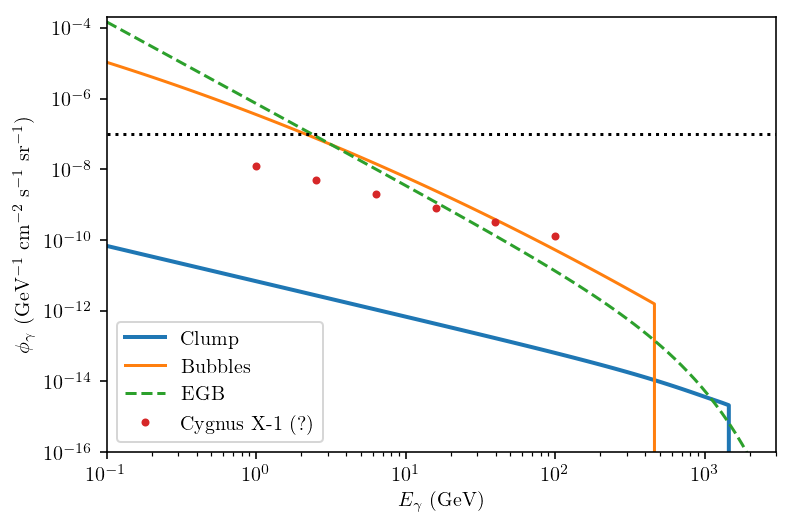

In [36]:
e_gs = np.logspace(-1, np.log10(3e3), 100)

plt.loglog(e_gs, dphi_de_g(e_gs, 1e-2, 1e-2, 1e3, gamma_nfw, "nfw", 1*np.pi/180),
           label="Clump", linewidth=2)
plt.loglog(e_gs, dphi_de_g_bubbles(e_gs), label="Bubbles")
plt.loglog(e_gs, dphi_de_egb_fermi(e_gs), '--', label="EGB")
plt.loglog(e_gs_cyg, dphi_de_g_cyg, '.', label="Cygnus X-1 (?)")
plt.axhline(1e-7, color='k', linestyle=':')

plt.autoscale(tight=True)
plt.ylim(1e-16, 2e-4)
plt.xlabel(r"$E_\gamma$ (GeV)")
plt.ylabel(r"$\phi_\gamma$ (GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$)")
plt.legend()

### Anisotropy

In [13]:
aniso_constr_nfw = anisotropy_constraint(dist_mg, r_s_mg, rho_s_nfw, gamma_nfw, "nfw", bg_dampe)

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/numpy/lib/function_base.py:2048: RuntimeWarning: divide by zero encountered in _helper (vectorized)
  outputs = ufunc(*inputs)
/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/numpy/lib/function_base.py:2048: RuntimeWarning: invalid value encountered in _helper (vectorized)
  outputs = ufunc(*inputs)


## Save results

In [ ]:
for var in ["dist", "r_s"]:
    np.savetxt(base_path_nfw + var + ".csv", eval(var), delimiter=',')

for var in ["rho_s", "rho_rel", "lum", "dphi_de_g", "extent", "lw",
            "rho_s_fermi_ps", "dphi_de_g_ext_rel"]:#, "aniso_constr"]:
    np.savetxt(base_path_nfw + var + ".csv", eval(var + "_nfw"), delimiter=',')

## Plot everything together

In [ ]:
levels_nfw = {"lum": [1e31, 2e31, 7e31, 2e32, 5e32, 2e33, 4e33, 1e34, 4e34],
              "rho_s": [1e-2, 0.1, 1, 10, 1e2, 1e3, 1e4],
              "dphi_de_g": [5e-17, 1e-16, 3e-16, 1e-15, 3e-15, 1e-14, 3e-14, 1e-13, 1e-12, 1e-10, 1e-8],
              "rho_rel": [2, 3, 10, 30, 100, 300, 1e3, 3e3, 3e4],
              "extent": [2, 5, 10, 20, 50, 100, 200, 300, 400, 450, 500, 550]}

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True,
                        figsize=(8, 10))

if gamma_nfw == 1:
    fig.suptitle(r"$\gamma_{\mathrm{NFW}} = " + "{:.0f}".format(gamma_nfw) + r"$")
elif gamma_nfw == 0.5:
    fig.suptitle(r"$\gamma_{\mathrm{NFW}} = " + "{:.1f}".format(gamma_nfw) + r"$")

for ax in axs.flatten():
    ax.set_xlabel(r"$d$ (kpc)")
    ax.set_ylabel(r"$r_s$ (kpc)")
    # Line width constraint
    ax.contourf(dist_mg, r_s_mg, lw_nfw, levels=[n_sigma, np.max(lw_nfw)],
                colors='k', alpha=0.2)
    # Point source constraint
    ax.contourf(dist_mg, r_s_mg, rho_s_fermi_ps_nfw - rho_s_nfw, levels=[-1e100, 0],
                colors=[colors[1]], alpha=0.2)
    # Extended source vs EGB
    ax.contourf(dist_mg, r_s_mg, dphi_de_g_ext_rel_nfw, levels=[1e1, 1e100],
                colors=[colors[8]], alpha=0.2)
    # Anisotropy constraint
#     ax.contourf(dist_mg, r_s_mg, aniso_constr_nfw, levels=[1e0, 1e100], colors=[colors[0]], alpha=0.2)

ax = axs[0, 0]
# Must be done before plotting to get label formatting right.
# Only need to do this for one subplot.
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(dist[[0, -1]])
ax.set_ylim(r_s[[0, -1]])
ax.set_title(r"$L$ (Hz)", pad=10)
sci_contours(dist_mg, r_s_mg, lum_nfw, ax, levels=levels_nfw["lum"])

ax = axs[0, 1]
ax.set_title(r"$\rho_s$ (GeV/cm$^3$)", pad=10)
sci_contours(dist_mg, r_s_mg, rho_s_nfw, ax, levels=levels_nfw["rho_s"])

ax = axs[1, 0]
ax.set_title(r"$\phi_\gamma(230\ \mathrm{GeV})$"
             r" (GeV cm$^2$ s sr)$^{-1}$", pad=10)
sci_contours(dist_mg, r_s_mg, dphi_de_g_nfw, ax, levels=levels_nfw["dphi_de_g"])

ax = axs[1, 1]
ax.set_title(r"$\frac{\rho_{\mathrm{NFW}}(d) +"
             r"\rho_\oplus}{\rho_\oplus}$", pad=10)
normal_contours(dist_mg, r_s_mg, rho_rel_nfw, ax, levels=levels_nfw["rho_rel"])

ax = axs[2, 0]
ax.set_title(r"$\frac{\theta_{68\%}(230\ \mathrm{GeV})}{\theta_{\rm PSF}}$", pad=10)
normal_contours(dist_mg, r_s_mg, extent_nfw/fermi_psf, ax, levels=levels_nfw["extent"])

ax = axs[2, 1]
ax.set_title(r"$p_{N {\rm -body}}$", pad=10)
# if gamma_nfw == 0.5:
#     sci_contours(dist_pr, r_s_pr, pr_nfw, ax, levels=np.logspace(-15, -12, 4))
# elif gamma_nfw == 1:
#     sci_contours(dist_pr, r_s_pr, pr_nfw, ax, levels=np.logspace(-13, -7, 7))


fig.tight_layout(rect=[0, 0.03, 1, 0.975])
fig.savefig("figures/contour_plots_nfw_gamma_{:.1f}.pdf".format(gamma_nfw))

In [ ]:
os.system("say 'Done with gamma NFW'")

## Ironing out the $\frac{\theta_{68\%}$ noise

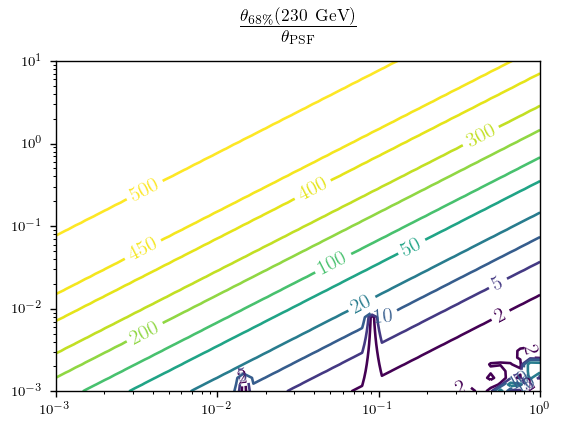

In [37]:
ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title(r"$\frac{\theta_{68\%}(230\ \mathrm{GeV})}{\theta_{\rm PSF}}$", pad=10)

normal_contours(dist, r_s, extent_nfw/fermi_psf, ax, levels=levels_nfw["extent"])

# smoothed_extents = np.exp(gaussian_filter(np.log10(extent_nfw), sigma=5))
# normal_contours(dist, r_s, smoothed_extents/fermi_psf, ax, levels=levels_nfw["extent"])

In [30]:
smoothed_extents[smoothed_extents / extent_nfw]

array([[  1.76159652,   1.98282756,   2.2155379 , ...,  37.03714411,
        122.68687276,  56.16316236],
       [  1.51652218,   1.69066672,   1.87457438, ...,   1.76359333,
         36.49534073, 115.515198  ],
       [  1.34372372,   1.48159936,   1.62742278, ...,  31.83759686,
          1.72756092,  36.08166807],
       ...,
       [  0.84002747,   0.84008582,   0.84013985, ...,   0.9364853 ,
          0.95565902,   0.98073426],
       [  0.83998159,   0.84002899,   0.84007178, ...,   0.91717511,
          0.93294833,   0.95367318],
       [  0.83993091,   0.83996865,   0.84000104, ...,   0.89812564,
          0.91094992,   0.92802663]])

In [19]:
from scipy.ndimage.filters import gaussian_filter

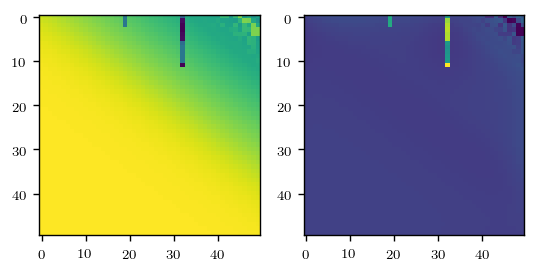

In [27]:
plt.subplot(1, 2, 1)
plt.imshow(np.log10(extent_nfw/fermi_psf))

plt.subplot(1, 2, 2)
plt.imshow(gaussian_filter(np.log10(extent_nfw/fermi_psf), sigma=5))

In [41]:
from scipy.interpolate import interp1d

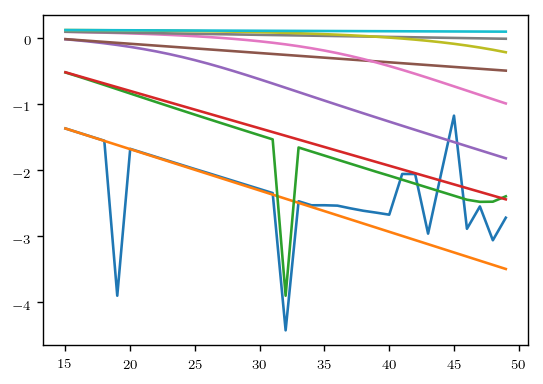

In [50]:
for i in range(extent_nfw.shape[0])[::10]:
    d_obs = np.arange(15)
    interp = interp1d(d_obs, np.log10(extent_nfw)[i, :d_obs.size],
                      fill_value="extrapolate")
    
    d_extrap = np.arange(d_obs.size, extent_nfw.shape[1])
    plt.plot(d_extrap, np.log10(extent_nfw)[i, d_obs.size:])
    plt.plot(d_extrap, interp(d_extrap))

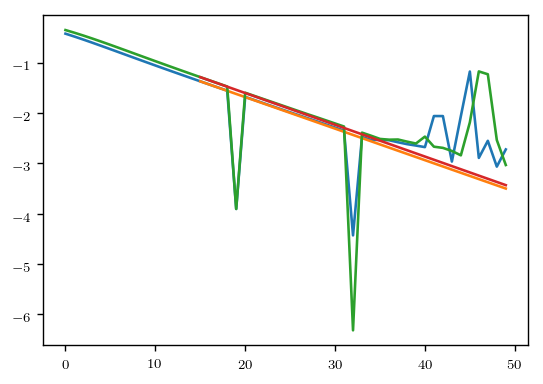

In [45]:
for i in [0, 1]:
    plt.plot(np.log10(extent_nfw)[i, :])
    interp = interp1d(range(15), np.log10(extent_nfw)[i, :15], fill_value="extrapolate")
    plt.plot(range(15, 50), interp(range(15, 50)))

# smoothed_extents = gaussian_filter(extent_nfw, sigma=2)
# plt.plot(np.log10(smoothed_extents)[0, :])
# plt.plot(np.log10(smoothed_extents)[1, :])

# Exponential/tidally truncated profile

In [24]:
gamma_exp = 0.52  # 25th percentile
# gamma_exp = 0.74  # median
# gamma_exp = 1.08  # 75th percentile
# gamma_exp = 2.25  # 9/4, the UCMH power law
# gamma_exp = 1.2  # the steepest inner slope this code works with is ~1.2

# Tightening up the plane (default: 50 points along each axis)
dist = np.logspace(-3, 0, 50)
r_s = np.logspace(-3, 1, 50)
dist_mg, r_s_mg = np.meshgrid(dist, r_s)

base_path_exp = 'data/exp_gamma_%.2f/' % gamma_exp

## Load results

In [14]:
for var in ["dist", "r_s"]:
    exec(var + " = np.loadtxt('" + base_path_exp + var + ".csv', delimiter=',')")
dist_mg, r_s_mg = np.meshgrid(dist, r_s)

for var in ["rho_s", "rho_rel", "lum", "dphi_de_g", "extent",
            "lw", "rho_s_fermi_ps", "dphi_de_g_ext_rel"]:  # aniso_constr]:
    exec(var + "_exp = np.loadtxt('" + base_path_exp + var + ".csv', delimiter=',')")

# Load likelihoods using Ben's processing
dist_pr, r_s_pr, pr_exp = np.loadtxt(
    pr_base_path + "exp/exp_gamma_%.2f.csv" % gamma_exp,
    delimiter=',').T

dist_pr = dist_pr.reshape(len(np.unique(dist_pr)), -1)
r_s_pr = r_s_pr.reshape(dist_pr.shape)
pr_exp = pr_exp.reshape(dist_pr.shape)

## Recompute

### $\rho_s$

In [25]:
rho_s_exp = rho_s_dampe(dist_mg, r_s_mg, gamma_exp, "exp")

#### Interpolate numerical glitches

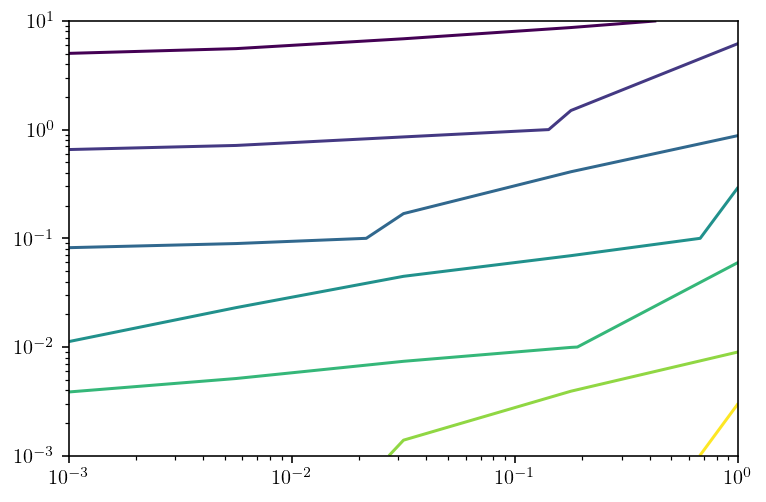

In [25]:
plt.xscale("log")
plt.yscale("log")
plt.contour(dist, r_s, np.log10(rho_s_exp))

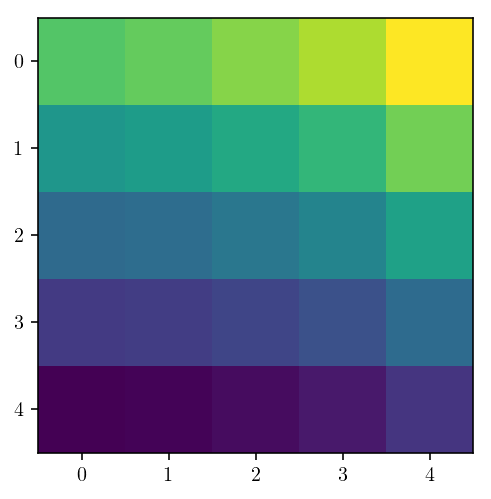

In [26]:
plt.imshow(np.log10(rho_s_exp))

#### Linearly interpolate nans

In [26]:
from scipy.interpolate import interp1d

for i in range(10, 15):
    obs_idx = np.where(~np.isnan(rho_s_exp[:, i]))[0]
    interp = interp1d(np.log(r_s[obs_idx]), np.log(rho_s_exp[obs_idx, i]),
                      fill_value="extrapolate")    
    nan_idx = np.where(np.isnan(rho_s_exp[:, i]))[0]
    rho_s_exp[nan_idx, i] = np.exp(interp(np.log(r_s[nan_idx])))

### $\frac{\rho_s + \rho_\oplus}{\rho_\oplus}$

In [27]:
rho_rel_exp = (rho(dist_mg, r_s_mg, rho_s_exp, gamma_exp, "exp") + rho_earth) / rho_earth

### $\mathcal{L}$

In [28]:
lum_exp = luminosity(r_s_mg, rho_s_exp, gamma_exp, "exp")

### $\frac{d\phi_\gamma}{d E_\gamma} (E_\gamma = 230$ GeV)

In [29]:
dphi_de_g_exp = dphi_de_g(e_gamma_ref, dist_mg, r_s_mg, rho_s_exp,
                          gamma_exp, "exp", fermi_psf)

In [ ]:
# from tt_clump import ann_plateau_radius as ann_plateau_radius_exp

# r_p_mg = ann_plateau_radius_exp(r_s_mg, rho_s_exp, gamma_exp)
# J_plateau_exp = 2*r_p_mg*rho_max**2*kpc_to_cm
# dphi_de_g_exp = (fermi_psf_solid_angle/4/np.pi * 3e-26/2 / dampe_excess_bin_high**2 *
#                  dn_de_gamma_AP(e_gamma_ref, dampe_excess_bin_high) * J_plateau_exp)

### $\frac{\theta_{68\%}}{\theta_{\mathrm{Fermi}}}$

In [30]:
extent_exp = gamma_ray_extent(dist_mg, r_s_mg, rho_s_exp, gamma_exp, "exp",
                              e_gamma_ref, thresh=0.68)

#### Ironing out the noise

In [31]:
extent_exp_coarse = gamma_ray_extent(dist_mg[::3, ::3], r_s_mg[::3, ::3],
                                     rho_s_exp[::3, ::3], gamma_exp, "exp",
                                     e_gamma_ref, thresh=0.68)

NameError: name 'levels_exp' is not defined

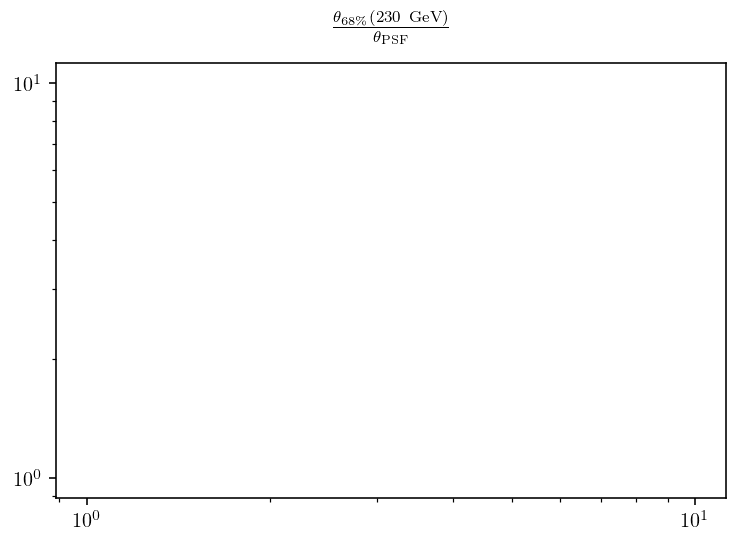

In [32]:
plt.xscale("log")
plt.yscale("log")
plt.title(r"$\frac{\theta_{68\%}(230\ \mathrm{GeV})}{\theta_{\rm PSF}}$", pad=10)

plt.contour(dist[::3], r_s[::3], extent_exp_coarse/fermi_psf,
            levels=levels_exp[gamma_exp]["extent"])

In [ ]:
os.system("say 'Done'")

### Line width constraint

In [ ]:
lw_exp = line_width_constraint(dist_mg, r_s_mg, rho_s_exp, gamma_exp, "exp", n_sigma)

### Fermi point source non-detection constraint

In [ ]:
rho_s_fermi_ps_exp = fermi_point_src_contraint(dist_mg, r_s_mg, gamma_exp, "exp")

### Comparison with Fermi EGB
Determine flux from $1^\circ$ observing region around clump relative to the Fermi EGB model. Since spectrum is harder than background model, set $E_\gamma \approx 1.5$ TeV.

In [ ]:
th_ref = 1. * np.pi / 180  # 1 degree
dphi_de_g_ext_exp = dphi_de_g(0.99*dampe_excess_bin_high, dist_mg, r_s_mg,
                              rho_s_exp, gamma_exp, "exp", th_ref)
dphi_de_g_ext_rel_exp = dphi_de_g_ext_exp / dphi_de_egb_fermi(dampe_excess_bin_high)

#### Comparing definitions of the constraint

In [4]:
def dphi_de_g_bubbles(es):
    def _helper(e):
        if e < 500:
            I = 6e-9
            alpha = 1.77
            beta= 0.063

            return I * (e / 10)**(-alpha - beta * np.log(e))
        else:
            return 0.
    return np.vectorize(_helper)(es)

In [5]:
e_gs_cyg = np.logspace(9, 11, 6) / 1e9
dphi_de_g_cyg = np.array(6 * [10**(-4.25) / (1e3 * 0.7 * 2*np.pi)]) / e_gs_cyg

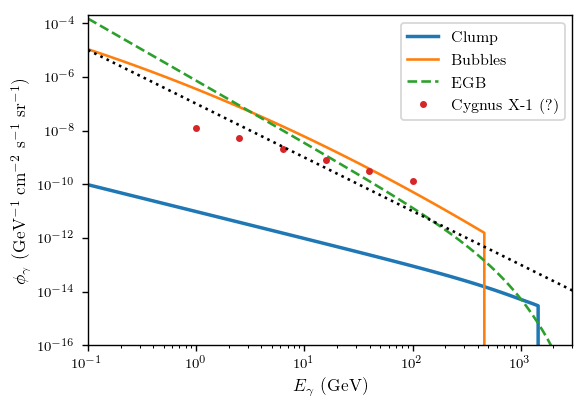

In [10]:
e_gs = np.logspace(-1, np.log10(3e3), 100)

plt.loglog(e_gs, dphi_de_g(e_gs, 1e-2, 1e-2, 1e3, gamma_exp, "exp", 1*np.pi/180),
           label="Clump", linewidth=2)
plt.loglog(e_gs, dphi_de_g_bubbles(e_gs), label="Bubbles")
plt.loglog(e_gs, dphi_de_egb_fermi(e_gs), '--', label="EGB")
plt.loglog(e_gs_cyg, dphi_de_g_cyg, '.', label="Cygnus X-1 (?)")
plt.loglog(e_gs, 1e-7 / e_gs**2, color='k', linestyle=':')

plt.autoscale(tight=True)
plt.ylim(1e-16, 2e-4)
plt.xlabel(r"$E_\gamma$ (GeV)")
plt.ylabel(r"$\phi_\gamma$ (GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$)")
plt.legend()

### Anisotropy

In [11]:
aniso_constr_exp = anisotropy_constraint(dist_mg, r_s_mg, rho_s_exp, gamma_exp, "exp", bg_dampe)

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/numpy/lib/function_base.py:2048: RuntimeWarning: divide by zero encountered in _helper (vectorized)
  outputs = ufunc(*inputs)
/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/numpy/lib/function_base.py:2048: RuntimeWarning: invalid value encountered in _helper (vectorized)
  outputs = ufunc(*inputs)


## Save results

In [ ]:
for var in ["dist", "r_s"]:
    np.savetxt(base_path_exp + var + ".csv", eval(var), delimiter=',')

for var in ["rho_s", "rho_rel", "lum", "dphi_de_g", "extent",
            "lw", "rho_s_fermi_ps", "dphi_de_g_ext_rel"]:#, "aniso_constr"]:
    np.savetxt(base_path_exp + var + ".csv", eval(var + "_exp"), delimiter=',')

## Plot everything together

In [ ]:
levels_exp = {}
levels_exp[0.52] = {"lum": [3e31, 1e32, 3e32, 1e33, 3e33, 7e33, 3e34, 1e35],
                    "rho_s": [1, 3, 10, 30, 1e2, 1e3, 1e4],
                    "dphi_de_g": [3e-18, 1e-17, 1e-16, 1e-15, 1e-14],
                    "rho_rel": [2, 10, 30, 100, 300, 1e3, 3e3, 3e4],
                    "extent": [2, 5, 10, 20, 50, 100, 400, 600]}
levels_exp[0.74] = {"lum": [3e31, 1e32, 3e32, 1e33, 3e33, 7e33, 3e34],
                    "rho_s": [1, 3, 10, 30, 1e2, 1e3, 1e4],
                    "dphi_de_g": [1e-16, 5e-16, 1e-15, 3e-15, 1e-14, 1e-13, 1e-12, 1e-10, 1e-8],
                    "rho_rel": [2, 10, 30, 100, 300, 1e3, 3e3, 3e4],
                    "extent": [2, 5, 10, 20, 50, 100, 400, 600]}
levels_exp[1.08] = {"lum": [1e31, 3e31, 1e32, 3e32, 1e33, 3e33, 7e33],
                    "rho_s": [1, 3, 10, 30, 1e2, 1e3, 1e4],
                    "dphi_de_g": [6e-16, 1e-15, 3e-15, 1e-14, 3e-14, 1e-13],
                    "rho_rel": [2, 10, 30, 100, 300, 1e3, 3e3, 3e4],
                    "extent": [2, 5, 10, 20, 50, 100, 400, 600]}
levels_exp[1.2] = {"lum": [4e48, 1e49, 3e49, 1e50, 3e50, 1e51, 3e51, 3e52, 4e54],
                    "rho_s": [1, 3, 10, 30, 1e2, 1e3, 1e4],
                    "dphi_de_g": [1e-16, 5e-16, 1e-15, 3e-15, 1e-14, 1e-13, 1e-12, 1e-10, 1e-8],
                    "rho_rel": [2, 3, 10, 30, 100, 300, 1e3, 3e3, 3e4],
                    "extent": [2, 5, 10, 20, 50, 100, 400, 600]}

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True,
                        figsize=(8, 10))

fig.suptitle(r"$\gamma_{\mathrm{exp}} = %.2f$" % gamma_exp)

for ax in axs.flatten():
    ax.set_xlabel(r"$d$ (kpc)")
    ax.set_ylabel(r"$R_b$ (kpc)")
    # Line width constraint
    ax.contourf(dist_mg, r_s_mg, lw_exp, levels=[n_sigma, np.max(lw_exp)],
                colors='k', alpha=0.2)
    # Point source constraint
    ax.contourf(dist_mg, r_s_mg, rho_s_fermi_ps_exp - rho_s_exp, levels=[-1e100, 0],
                colors=[colors[1]], alpha=0.2)
    # Extended source vs EGB
    ax.contourf(dist_mg, r_s_mg, dphi_de_g_ext_rel_exp, levels=[1e1, 1e100],
                colors=[colors[8]], alpha=0.2)
#     # Anisotropy constraint
#     ax.contourf(dist_mg, r_s_mg, aniso_constr_exp, levels=[1e0, 1e100], colors=[colors[0]], alpha=0.2)

ax = axs[0, 0]
# Must be done before plotting to get label formatting right.
# Only need to do this for one subplot.
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(dist[[0, -1]])
ax.set_ylim(r_s[[0, -1]])
ax.set_title(r"$L$ (Hz)", pad=10)
sci_contours(dist_mg, r_s_mg, lum_exp, ax, levels=levels_exp[gamma_exp]["lum"])

ax = axs[0, 1]
ax.set_title(r"$\rho_0$ (GeV/cm$^3$)", pad=10)
normal_contours(dist_mg, r_s_mg, rho_s_exp, ax, levels=levels_exp[gamma_exp]["rho_s"])

ax = axs[1, 0]
ax.set_title(r"$\phi_\gamma(230\ \mathrm{GeV})$"
             r" (GeV cm$^2$ s sr)$^{-1}$", pad=10)
sci_contours(dist_mg, r_s_mg, dphi_de_g_exp, ax, fmt="0.2f")#, levels=levels_exp[gamma_exp]["dphi_de_g"])

ax = axs[1, 1]
ax.set_title(r"$\frac{\rho_{\mathrm{exp}}(d) +"
             r"\rho_\oplus}{\rho_\oplus}$", pad=10)
normal_contours(dist_mg, r_s_mg, rho_rel_exp, ax, levels=levels_exp[gamma_exp]["rho_rel"])

ax = axs[2, 0]
ax.set_title(r"$\frac{\theta_{68\%}(230\ \mathrm{GeV})}{\theta_{\rm PSF}}$", pad=10)
normal_contours(dist_mg, r_s_mg, extent_exp/fermi_psf, ax,
                levels=levels_exp[gamma_exp]["extent"])

ax = axs[2, 1]
ax.set_title(r"$p_{N{\rm -body}}$", pad=10)
# log_contours(dist_pr, r_s_pr, pr_exp, ax, levels=np.logspace(-9, -4, num=6))

fig.tight_layout(rect=[0, 0.03, 1, 0.975])
fig.savefig("figures/contour_plots_exp_gamma_%.2f.pdf" % gamma_exp)

In [ ]:
os.system("say 'Done with exp profile'")

## Debugging

Annihilation plateau radius

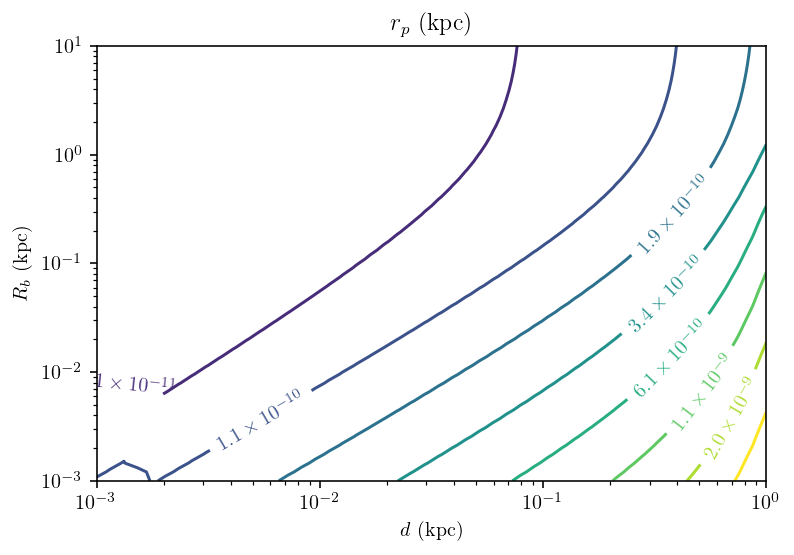

In [85]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$R_b$ (kpc)")
plt.title(r"$r_p$ (kpc)")

r_p_mg = ann_plateau_radius_exp(r_s_mg, rho_s_exp, gamma_exp)
sci_contours(dist_mg, r_s_mg, r_p_mg, plt.gca(), log_levels(r_p_mg), fmt="0.1f")

Comparing luminosities for exponential clump: plateau only, power law, full result. They all match reasonably well.

In [91]:
3e-26 / (2*dampe_excess_bin_high**2) * 4./3.*np.pi*(1e-10*kpc_to_cm)**3 * rho_max**2

1.0877219238817702e+25

In [95]:
lum_pl(1e-10, 0.1, 1.08)

1.4104569729363806e+33

In [96]:
luminosity(0.1, 10., 1.08, "exp")

array(1.51584676e+32)

Looks like it's correct. Also below: comparison with power law.

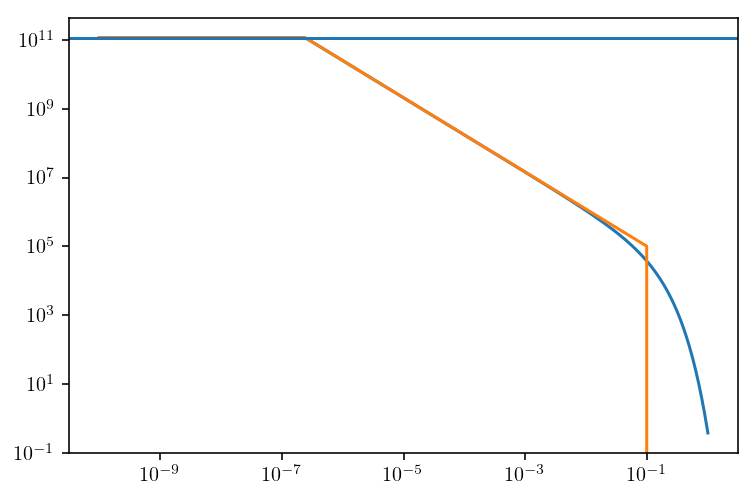

In [90]:
rs = np.logspace(-10, 0, 200)

r_p = ann_plateau_radius_exp(0.1, 1e5, gamma_exp)

plt.loglog(rs, rho(rs, 0.1, 1e5, gamma_exp, "exp"))
plt.loglog(rs, rho_pl(rs, r_p, 0.1, gamma_exp))
plt.axhline(rho_max)

$J$-factor: exponential clump

In [31]:
from finite_clump_vectorized import J_factor

In [83]:
th_max = fermi_psf
dOmega = 2.*np.pi*(1. - np.cos(th_max))
J_exp = J_factor(dist_mg, r_s_mg, rho_s_exp, gamma_exp, "exp", th_max)

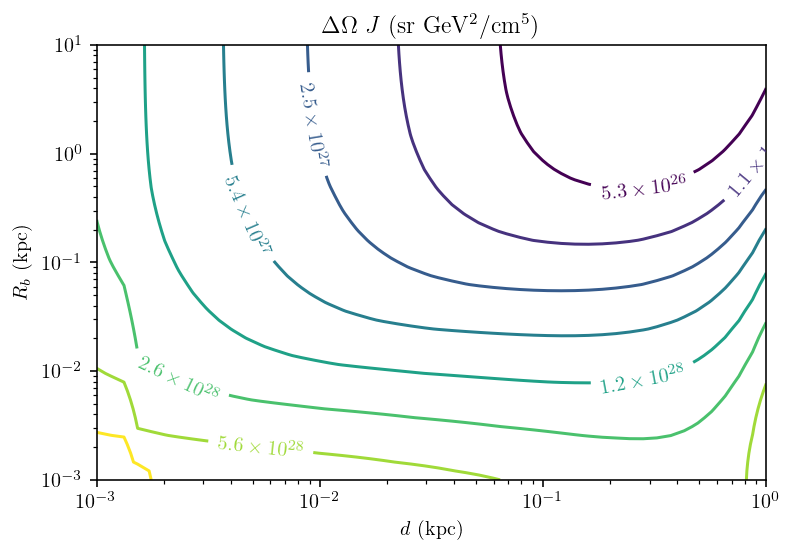

In [89]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$R_b$ (kpc)")
plt.title(r"$\Delta \Omega ~ J$ (sr GeV$^2$/cm$^5$)")

sci_contours(dist_mg, r_s_mg, J_exp, plt.gca(), fmt="0.1f")

$J$-factor: plateau contribution for exponential clump

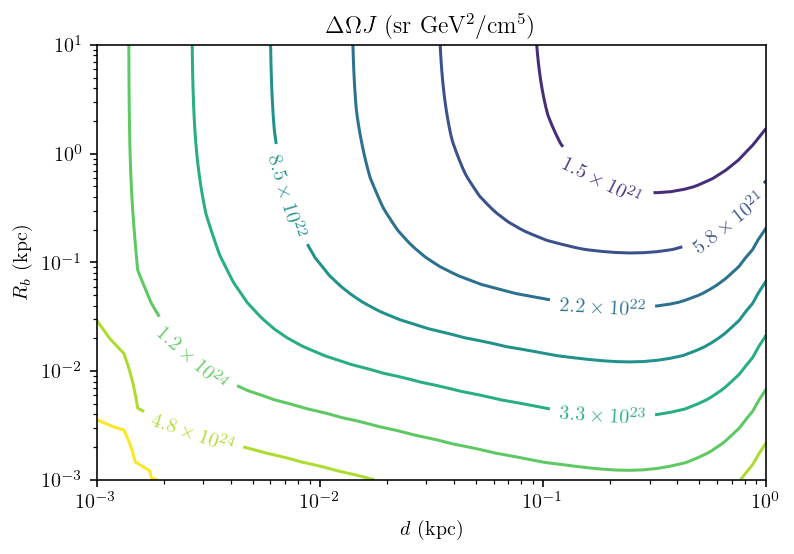

In [100]:
# J_plateau_exp = 2*r_p_mg*kpc_to_cm*rho_max**2 * 2*np.pi/dOmega
J_plateau_exp = 2*np.pi / dOmega * 1 / dist_mg**2 * 4/3.*np.pi*r_p_mg**3 * rho_max**2 * kpc_to_cm

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$R_b$ (kpc)")
plt.title(r"$\Delta \Omega J$ (sr GeV$^2$/cm$^5$)")

sci_contours(dist_mg, r_s_mg, J_plateau_exp, plt.gca(), fmt="0.1f")

Comparing power law and exp. clump luminosities. These should be very close, but the power law ones are 4 times larger!!!

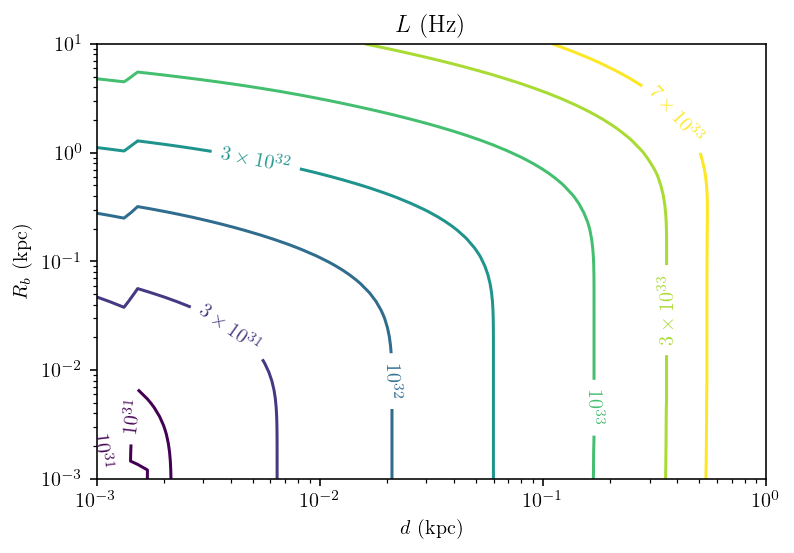

In [83]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$R_b$ (kpc)")
plt.title(r"$L$ (Hz)")

lums_pl = lum_pl(r_p_mg, r_tr_mg, gamma_exp)
sci_contours(dist_mg, r_s_mg, lums_pl/4, plt.gca(), levels_exp[gamma_exp]["lum"])

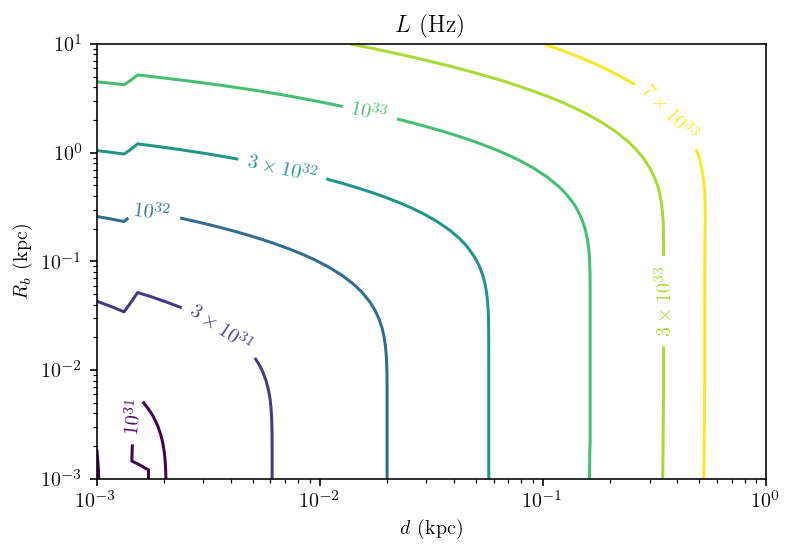

In [76]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$R_b$ (kpc)")
plt.title(r"$L$ (Hz)")

sci_contours(dist_mg, r_s_mg, lum_exp, plt.gca(), levels_exp[gamma_exp]["lum"])

# Extreme power law profile

When I set the inner slope $\nu$ to extreme values like $3/2$ or $9/4$, the calculation suffers from numerical issues. Instead, I will try computing the luminosity for a point source at a particular distance, and use Ben's estimate for the truncation radius to convert this to a density normalization for the halo.

Consistency check: the truncation radius needs to be large enough for the luminosity to match up with that of the point source.

In [2]:
from pointlike_clump import lum_dampe_pt, dphi_de_e_pt, dphi_de_gamma_pt
from power_law_clump import line_width_constraint as line_width_constraint_pl

from power_law_clump import rho as rho_pl
from power_law_clump import ann_plateau_radius as ann_plateau_radius_pl
from power_law_clump import lum as lum_pl

In [62]:
gamma_pl = 3/2.
dist = np.logspace(-3, 0, 50)
r_tr = np.logspace(-3, 1, 50)
dist_mg, r_tr_mg = np.meshgrid(dist, r_tr)

base_path_pl = 'data/pl_gamma_%.2f/' % gamma_pl

Point-source luminosities

In [63]:
lum_pt = lum_dampe_pt(dist)
lum_pt_grid = np.stack(r_tr.shape[0]*[lum_pt])
lum_pt_grid[lum_pt_grid < 0] = np.nan

Annihilation plateau radii

In [64]:
r_p = ann_plateau_radius_pl(r_tr_mg, lum_pt_grid, gamma_pl)

# np.savetxt("/Users/acoogan/Desktop/lum_pt_grid_3_2.csv", lum_pt_grid, delimiter=",")
# np.savetxt("/Users/acoogan/Desktop/r_p_grid_3_2.csv", r_p, delimiter=",")

Local density enhancement

In [65]:
rho_rel_pl = (rho_pl(dist_mg, r_p, r_tr_mg, gamma_pl) + rho_earth) / rho_earth

Line width constraint

In [66]:
lw_pt_grid = line_width_constraint_pl(dist_mg, r_p, r_tr_mg, gamma_pl)

Gamma ray flux from point-like clump

In [67]:
dphi_de_g_pt = dphi_de_gamma_pt(e_gamma_ref, dist, dampe_excess_bin_high, lum_pt)
dphi_de_g_pt_grid = np.stack(r_tr.shape[0]*[dphi_de_g_pt])
dphi_de_g_pt_grid[dphi_de_g_pt_grid < 0] = np.nan

Gamma ray flux from power law clump

In [68]:
# from power_law_clump import dphi_de_g as dphi_de_g_pl
# from power_law_clump import J_factor as J_factor_pl

# dphi_de_g = dphi_de_g_pl(e_gamma_ref, dist_mg, r_p, r_tr_mg, gamma_pl, fermi_psf)

Gamma ray flux from the annihilation plateau for a power-law clump

In [69]:
J_factors_plateau = 1 / fermi_psf_solid_angle / dist_mg**2 * 4./3.*np.pi*r_p**3 * rho_max**2 * kpc_to_cm
dphi_de_g_plateau = (fermi_psf_solid_angle/(4*np.pi) *
                     3e-26/(2*dampe_excess_bin_high**2) *
                     dn_de_gamma_AP(e_gamma_ref, dampe_excess_bin_high) *
                     J_factors_plateau)

In [82]:
r_cut_mg = 50*r_p
J_factors = 1 / fermi_psf_solid_angle / dist_mg**2
if gamma_pl != 3/2.:
    J_factors *= (4*np.pi/(9.-6.*gamma_pl) * rho_max**2 *
                        (3 * r_cut_mg**3 * (r_p / r_cut_mg)**(2*gamma_pl) - 2*gamma_pl*r_p**3)) * kpc_to_cm
elif gamma_pl == 3/2.:
#     J_factors = np.loadtxt("data/J_grid_3_2.csv")
    J_factors *= 4./3.*np.pi*r_p**3 * rho_max**2 * (1. + 3.*np.log(r_cut_mg/r_p)) * kpc_to_cm
    
dphi_de_g = (fermi_psf_solid_angle/(4*np.pi) *
             3e-26/(2*dampe_excess_bin_high**2) *
             dn_de_gamma_AP(e_gamma_ref, dampe_excess_bin_high) *
             J_factors)
dphi_de_g[dphi_de_g < 0] = np.nan

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  


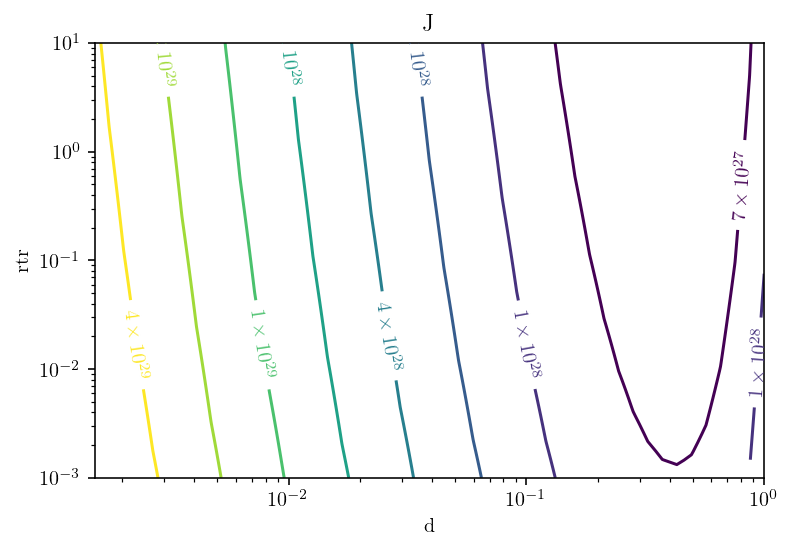

In [83]:
plt.xscale("log")
plt.yscale("log")
plt.title("J")
plt.xlabel("d")
plt.ylabel("rtr")
sci_contours(dist_mg[:, 3:], r_tr_mg[:, 3:], J_factors[:, 3:], plt.gca(), levels=log_levels(J_factors[:, 3:]))

Point source gamma ray constraint

In [52]:
from constants import fermi_pt_src_sens_120_45 as fermi_pt_src_sens
fermi_pt_src_sens(e_gamma_ref)

array(7.98754116e-15)

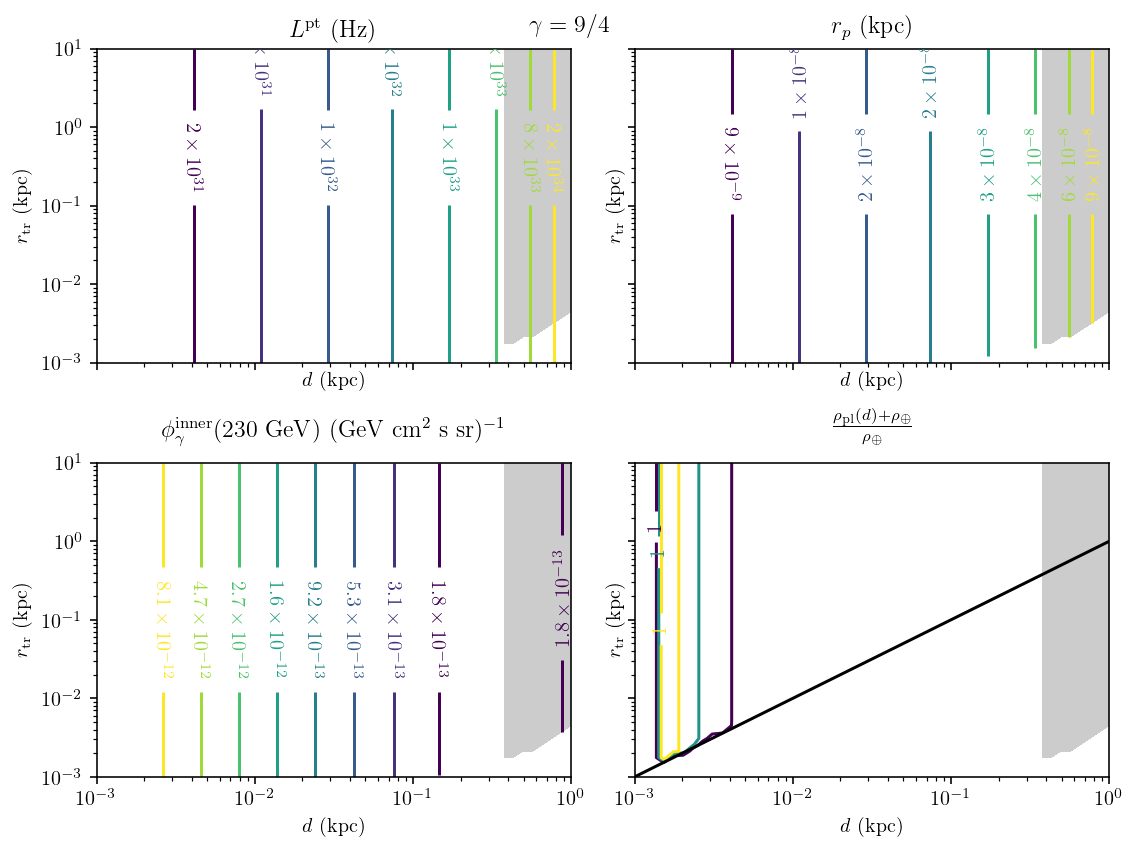

In [53]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 6))

for ax in axs.flatten():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(dist[[0, -1]])
    ax.set_ylim(r_tr[[0, -1]])
    ax.set_xlabel(r"$d$ (kpc)")
    ax.set_ylabel(r"$r_{\mathrm{tr}}$ (kpc)")
    # Line width constraint
    ax.contourf(dist_mg, r_tr_mg, lw_pt_grid, levels=[n_sigma, np.max(lw_pt_grid)],
                colors='k', alpha=0.2)

ax = axs[0, 0]
ax.set_title(r"$L^{\mathrm{pt}}$ (Hz)")
sci_contours(dist_mg, r_tr_mg, lum_pt_grid, ax, levels=log_levels(lum_pt_grid))

ax = axs[0, 1]
ax.set_title(r"$r_p$ (kpc)")
sci_contours(dist_mg, r_tr_mg, r_p, ax, levels=log_levels(r_p))

ax = axs[1, 0]
ax.set_title(r"$\phi_\gamma^{\mathrm{inner}}(230\ \mathrm{GeV})$"
             r" (GeV cm$^2$ s sr)$^{-1}$", pad=10)
# sci_contours(dist_mg, r_tr_mg, dphi_de_g_plateau, ax,
#              levels=log_levels(dphi_de_g_plateau))
sci_contours(dist_mg, r_tr_mg, dphi_de_g, ax,
             levels=log_levels(dphi_de_g), fmt="0.1f")

ax = axs[1, 1]
ax.set_title(r"$\frac{\rho_{\mathrm{pl}}(d) +"
             r"\rho_\oplus}{\rho_\oplus}$", pad=10)
normal_contours(dist_mg, r_tr_mg, rho_rel_pl, ax, levels=log_levels(rho_rel_pl, 5))
ax.plot(dist, dist, color='k')

fig.suptitle(r"$\gamma=9/4$")
fig.tight_layout()
fig.savefig("figures/contour_plots_pl_9_4.pdf")

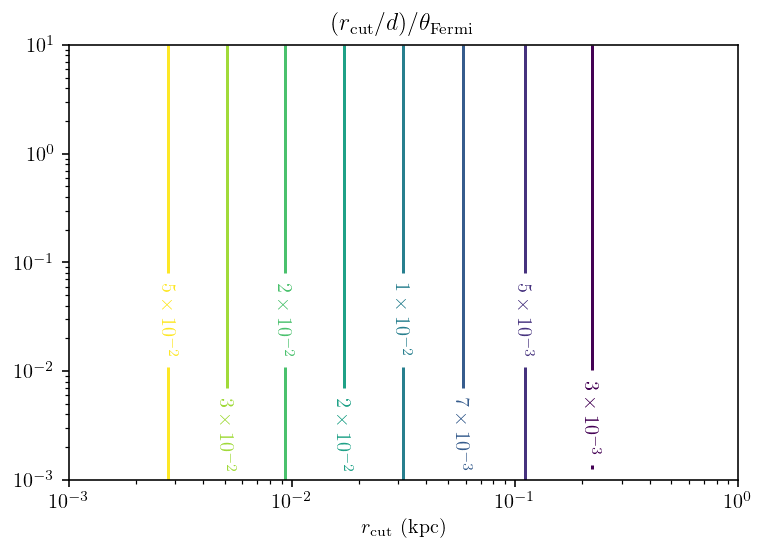

In [54]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$d$ (kpc)")
plt.xlabel(r"$r_{\mathrm{cut}}$ (kpc)")
plt.title(r"$(r_{\mathrm{cut}} / d) / \theta_{\mathrm{Fermi}}$")
th_cut = r_cut_mg / dist_mg / fermi_psf
sci_contours(dist_mg, r_tr_mg, th_cut, plt.gca(), levels=log_levels(th_cut))